In [1]:
import os
import sys
sys.path.append('../')
os.chdir('../')

from utilidades import *
import matplotlib
from matplotlib import pyplot

In [2]:
local_data = load_data(aggregate=False)
local_data_index = pd.MultiIndex.from_product(
    [local_data.keys(), ['active_cases', 'cases', 'death', 'recovered', 'pending', 'discarded']]
)

local_data = pd.DataFrame(it.chain(*local_data.values())).T
local_data.columns = local_data_index

In [101]:
def get_df(data, key):
    data = data.loc[pd.IndexSlice[:],pd.IndexSlice[:, key]].copy()
    data.columns = data.columns.droplevel(1)
    return data
           
local_cases = get_df(local_data, 'cases')
local_deaths = get_df(local_data, 'death')
local_pending = get_df(local_data, 'pending')
local_discarded = get_df(local_data, 'discarded')

local_new_cases = local_cases.diff()
local_new_cases[local_new_cases < 0] = 0

# case fatality rate
cfr = local_deaths / local_cases
cfr[cfr == 0] = np.nan
cfr = cfr.rolling(window=7).mean()

local_tests = local_discarded + local_cases
local_daily_tests = local_tests.diff()
local_daily_tests[local_daily_tests < local_new_cases] = local_new_cases[
    local_daily_tests < local_new_cases
]
local_daily_tests[local_daily_tests < 1] = 1

local_new_cases[local_new_cases < 1] = 1
test_case_ratio = local_daily_tests / local_new_cases
test_case_ratio[test_case_ratio < 1] = 1

cum_test_case_ratio = local_daily_tests.cumsum() / (
    local_new_cases[local_daily_tests.first_valid_index():].cumsum()
)
cum_test_case_ratio[cum_test_case_ratio < 1] = 1
cum_test_case_ratio[cum_test_case_ratio > 30] = 30

local_pending = local_pending
local_pending_capacity_ratio = (local_daily_tests + local_pending) / local_daily_tests

sample_prevalence = 1 / test_case_ratio
local_pending_capacity_ratio = 1 - 1 / local_pending_capacity_ratio

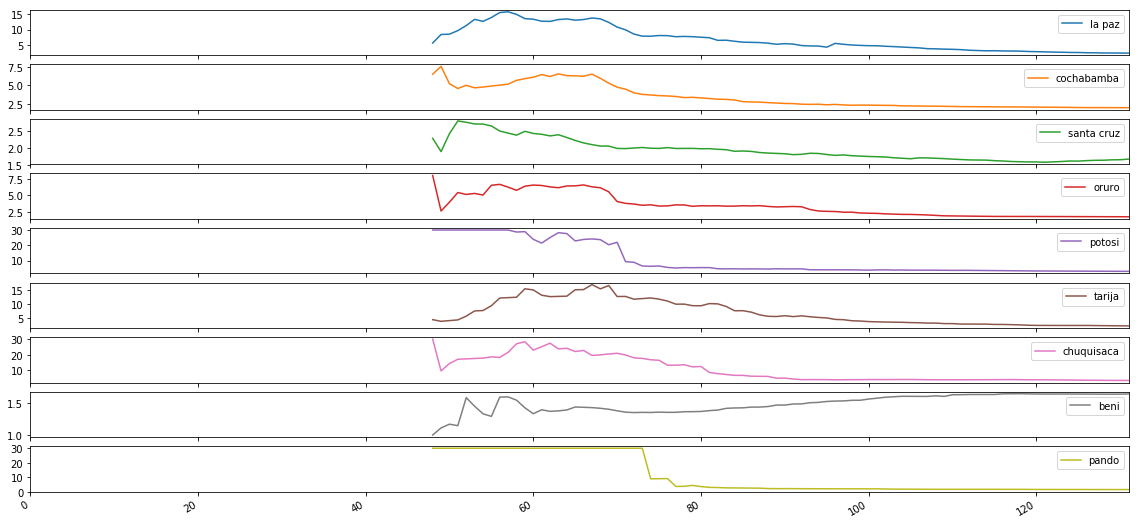

In [78]:
axs = cum_test_case_ratio.plot(subplots=True)

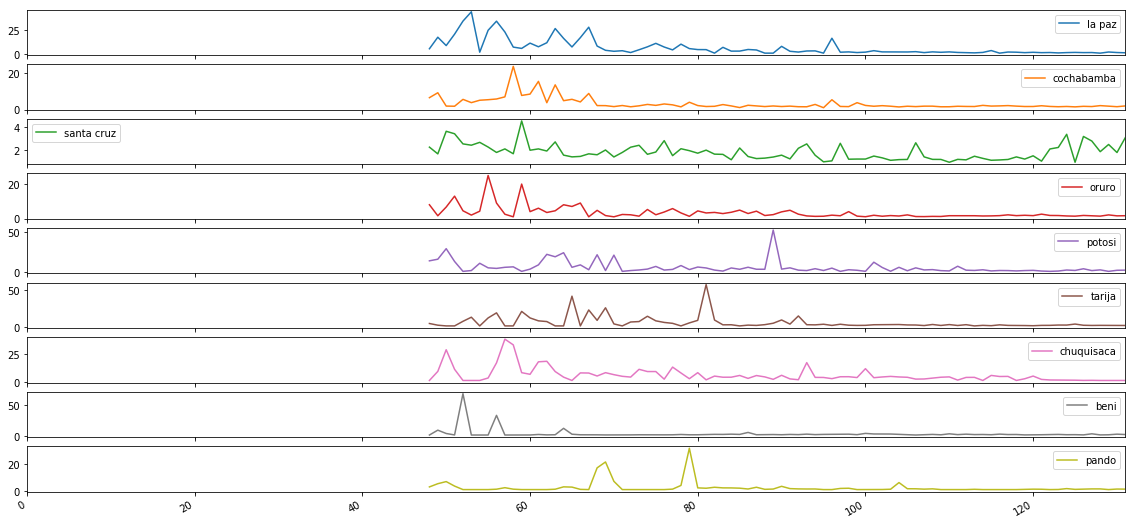

In [87]:
axs = test_case_ratio.plot(subplots=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'cfr')

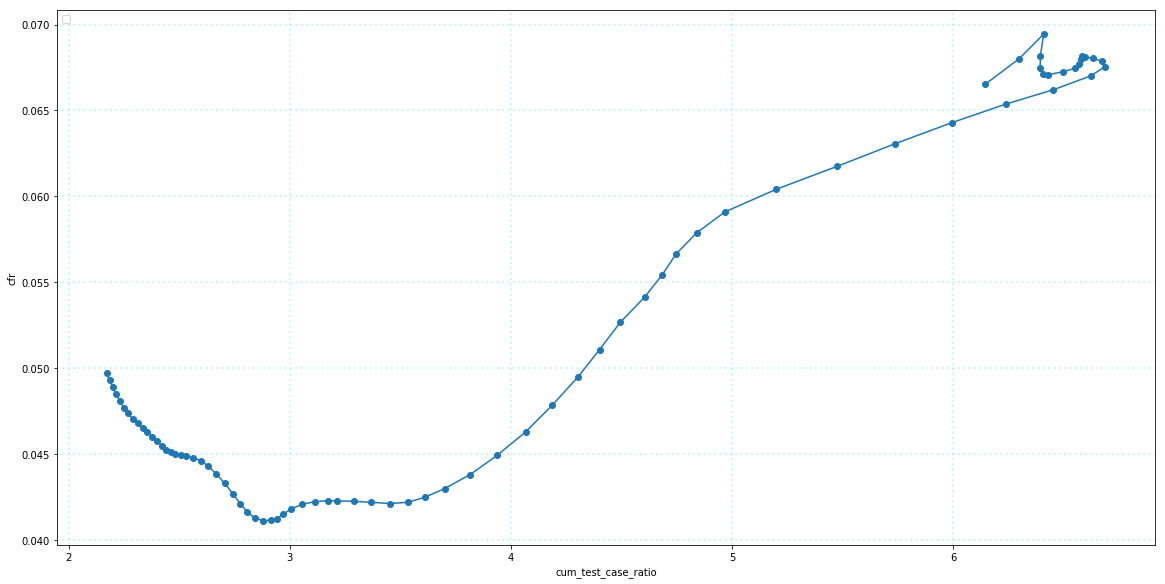

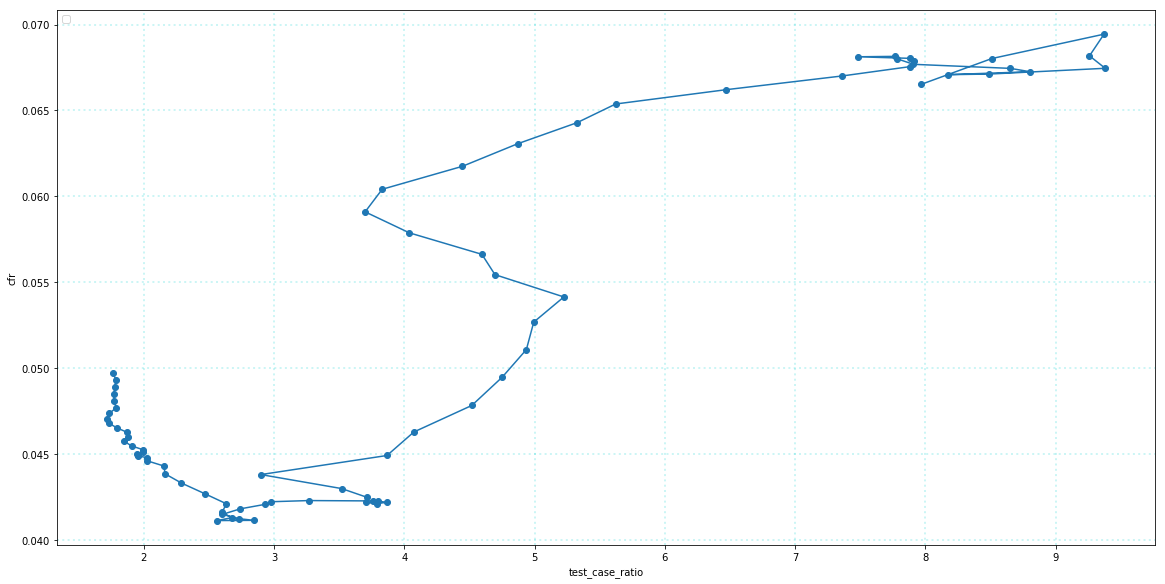

In [103]:
WINDOW_SIZE = 7
def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.legend(loc='upper left')
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    
    return ax
    
# ax = cfr.mean(axis=1).plot(label='cfr')
# ax = test_case_ratio.mean(axis=1).plot(label='sample prevalence')
# ax = local_pending_capacity_ratio.mean(axis=1).plot(label='pending tests')
# stylize_ax(ax)

def plot_rel(x, y):
    fig, ax = pyplot.subplots()
    ax.plot(
        x.rolling(window=WINDOW_SIZE).mean(), 
        y.rolling(window=WINDOW_SIZE).mean(), 
        marker='o'
    )
    return stylize_ax(ax)
    
    
ax = plot_rel(x=cum_test_case_ratio.mean(axis=1), y=cfr.mean(axis=1))
ax.set_xlabel('cum_test_case_ratio')
ax.set_ylabel('cfr')

ax = plot_rel(x=test_case_ratio.mean(axis=1), y=cfr.mean(axis=1))
ax.set_xlabel('test_case_ratio')
ax.set_ylabel('cfr')

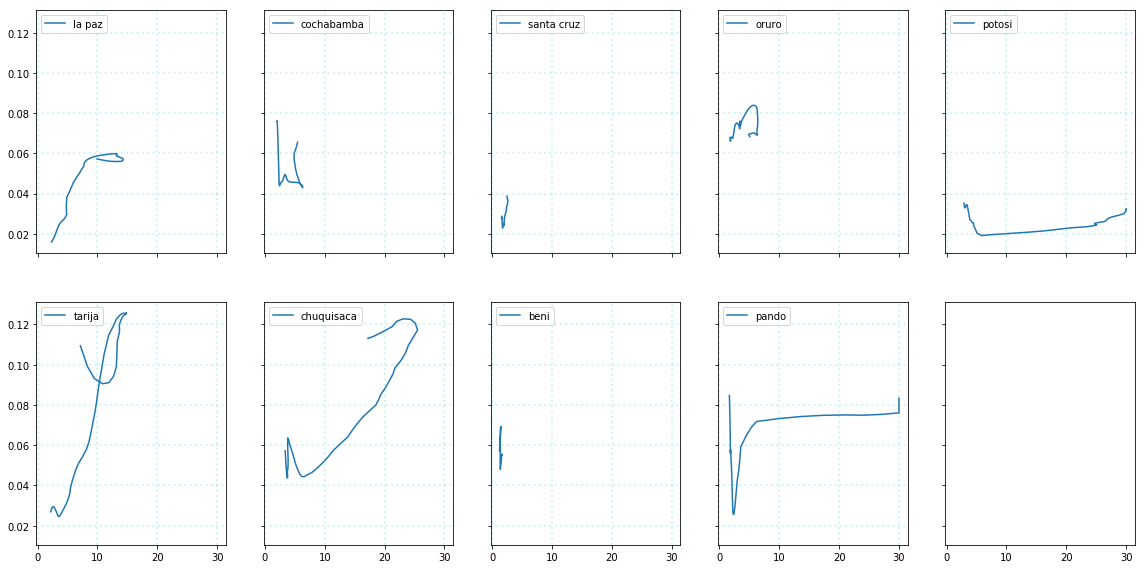

In [80]:
def subplots(data_x, data_y, logy=False):
    fig, axs = pyplot.subplots(ncols=5, nrows=2, sharey=True, sharex=True)
    faxs = axs.flatten()
 
    for idx, key in enumerate(data_x.columns):
        local_data_x = data_x[key]
        local_data_y = data_y[key]
        faxs[idx].plot(local_data_x, local_data_y, label=key)
        if logy:
            faxs[idx].set_xscale('log')
            
        stylize_ax(faxs[idx])
        
subplots(
    cum_test_case_ratio.rolling(window=WINDOW_SIZE).mean(), 
    cfr.rolling(window=WINDOW_SIZE).mean(),
)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'local_pending_capacity_ratio')

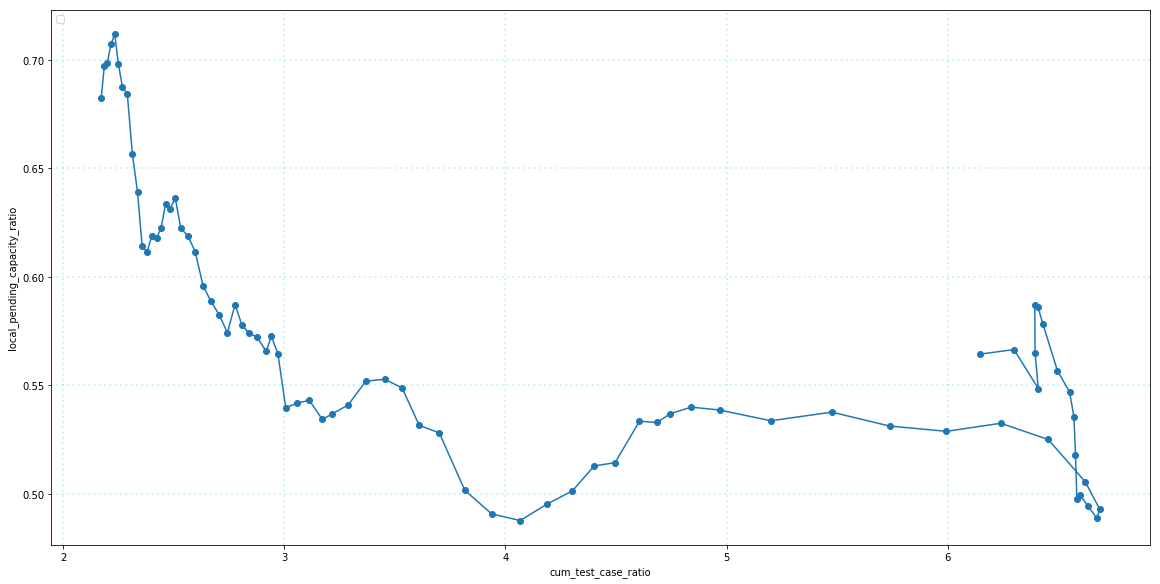

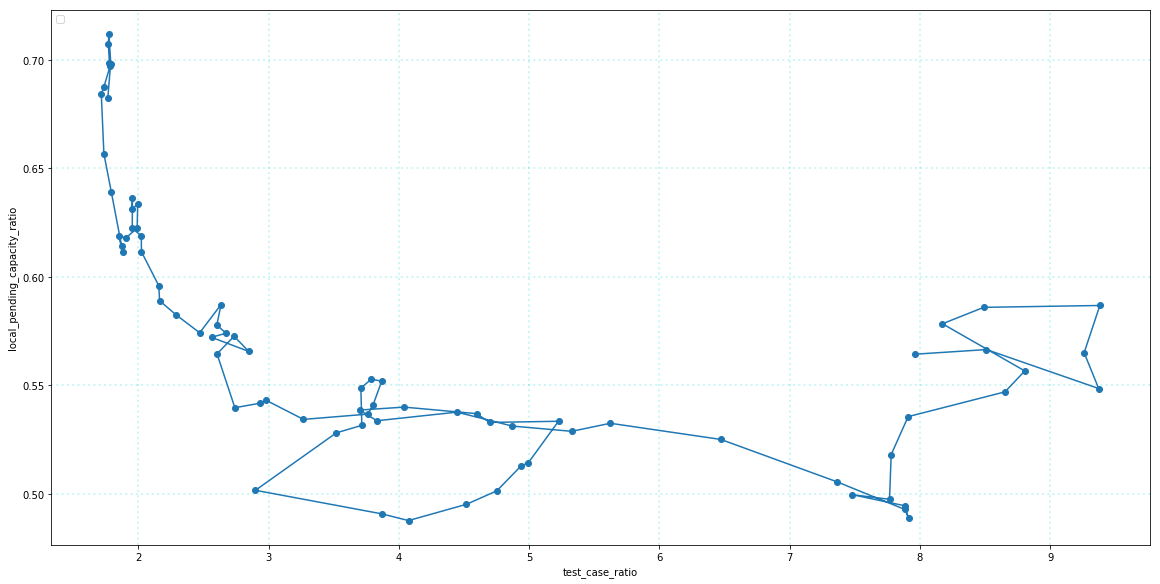

In [104]:
ax = plot_rel(cum_test_case_ratio.mean(axis=1), local_pending_capacity_ratio.mean(axis=1))
ax.set_xlabel('cum_test_case_ratio')
ax.set_ylabel('local_pending_capacity_ratio')

ax = plot_rel(test_case_ratio.mean(axis=1), local_pending_capacity_ratio.mean(axis=1))
ax.set_xlabel('test_case_ratio')
ax.set_ylabel('local_pending_capacity_ratio')

# fig, ax = pyplot.subplots()
# ax.plot(local_pending_capacity_ratio.mean(axis=1), cfr.mean(axis=1), marker='o')
# # stylize_ax(ax)

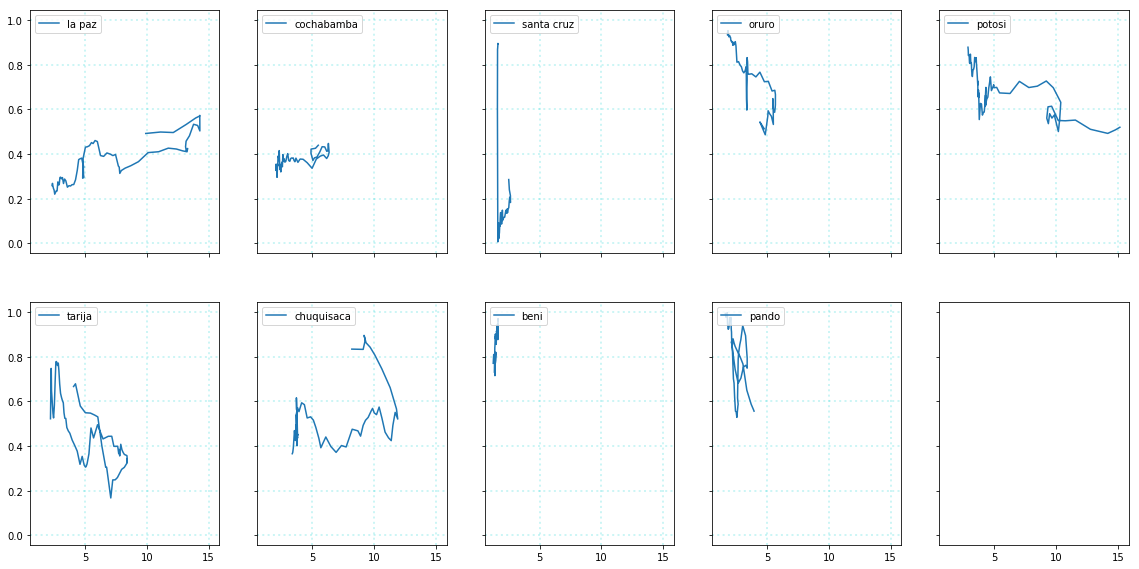

In [105]:
subplots(
    cum_test_case_ratio.rolling(window=WINDOW_SIZE).mean(), 
    local_pending_capacity_ratio.rolling(window=WINDOW_SIZE).mean(), 
    logy=False
)

No handles with labels found to put in legend.


Text(0, 0.5, 'local_pending_capacity_ratio')

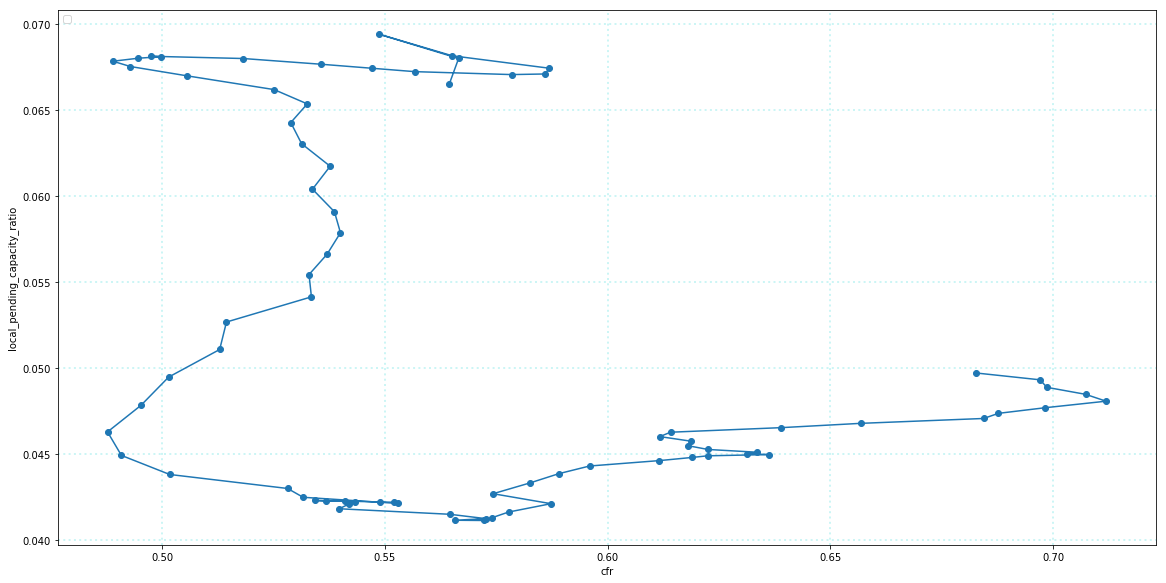

In [109]:
ax = plot_rel(local_pending_capacity_ratio.mean(axis=1),cfr.mean(axis=1),)
ax.set_xlabel('cfr')
ax.set_ylabel('local_pending_capacity_ratio')

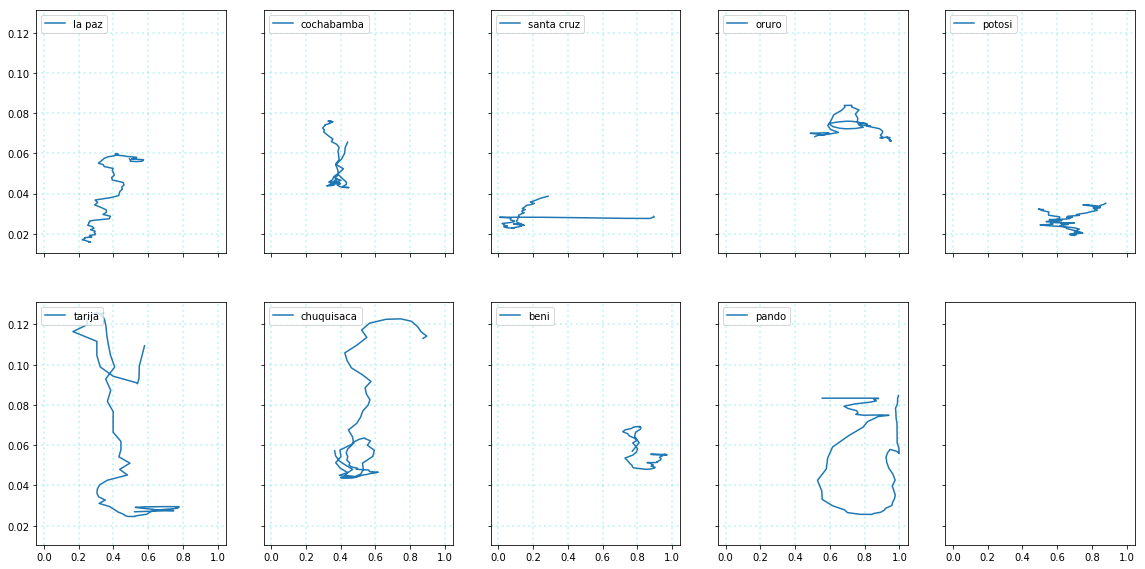

In [112]:
subplots(
    local_pending_capacity_ratio.rolling(window=WINDOW_SIZE).mean(), 
    cfr.rolling(window=WINDOW_SIZE).mean(), 
    logy=False
)

##### Algo de latex

$prev = \frac{P_{pop}}{n}$   
$n$ - size of Population   
$z$ - the proportion of the population sampled per iteration $t$   
$t$ - subsample   
bias; $\lambda > 1$; $\lambda = 1$ Totally random   
$r_t$ - The prevalence of COVID-19 positive individuals in the unsampled population; $r_0 = prev$   
$p_t$ - The prevalence of COVID-19 positive individuals in the sampled population

$$r_{t + 1} = \frac{r_t - \lambda * r_t * z}{1 - z}$$   

$$ r_{t + 1} * (1 - z) = r_t * (1 - \lambda * z)$$

$$ 1 - \frac{r_{t + 1} * (1 - z)}{r_t} = \lambda * z$$

$$ \lambda = \frac{1 - \frac{r_{t + 1}}{r_t} * (1 - z)}{z}$$

$$ \lambda = \frac{1 - \Delta * (1 - z)}{z}$$

$$...$$
$$r_{t + 1} * (1 - z) = r_t * (1 - \lambda * z)$$

$$r_{t + 1} - r_t = r_{t + 1} * z - \lambda * r_t *z$$


$$r_{t + 1} - r_t = z * (r_{t + 1} - \lambda * r_t)$$


$$z = \frac{r_{t + 1} - r_t}{r_{t + 1} - \lambda * r_t}$$

$$...$$

$$p_t = \lambda * r_t$$

$$p_t = \frac{P_{sample}}{T_{sample}}; z = \frac{T_{sample}}{n}$$

In [113]:
sample_prevalence = 1 / cum_test_case_ratio
sample_prevalence

,la paz,cochabamba,santa cruz,oruro,potosi,tarija,chuquisaca,beni,pando
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
127,0.424691,0.490598,0.613606,0.549325,0.346666,0.450692,0.291190,0.611225,0.609862
128,0.435742,0.488938,0.612718,0.552476,0.346697,0.454881,0.297850,0.611386,0.610085
129,0.436066,0.490054,0.608323,0.551254,0.349074,0.461069,0.300806,0.611732,0.610426
130,0.439108,0.491472,0.607372,0.552772,0.349343,0.466885,0.303305,0.611171,0.611916


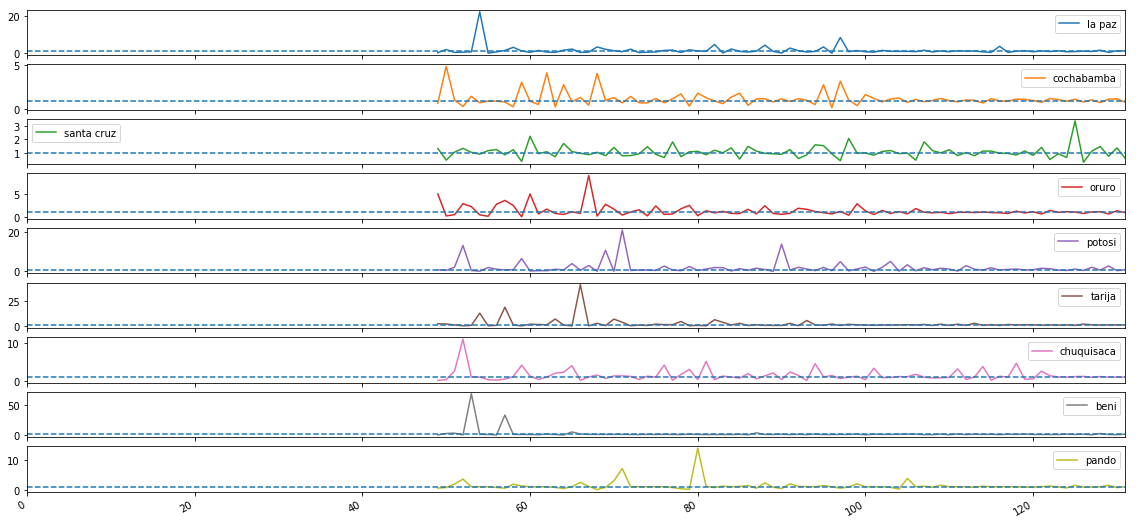

In [119]:
axs = np.exp(np.log(1 / test_case_ratio).diff()).plot(subplots=True)
_ = [ax.axhline(1., linestyle='--') for ax in axs.flatten()]

In [11]:
population = {}
for key, data in load_population_data(1, 0).items():
    population[key[1].lower()] = data['total']
population = pd.Series(population)
population = population[local_daily_tests.columns]

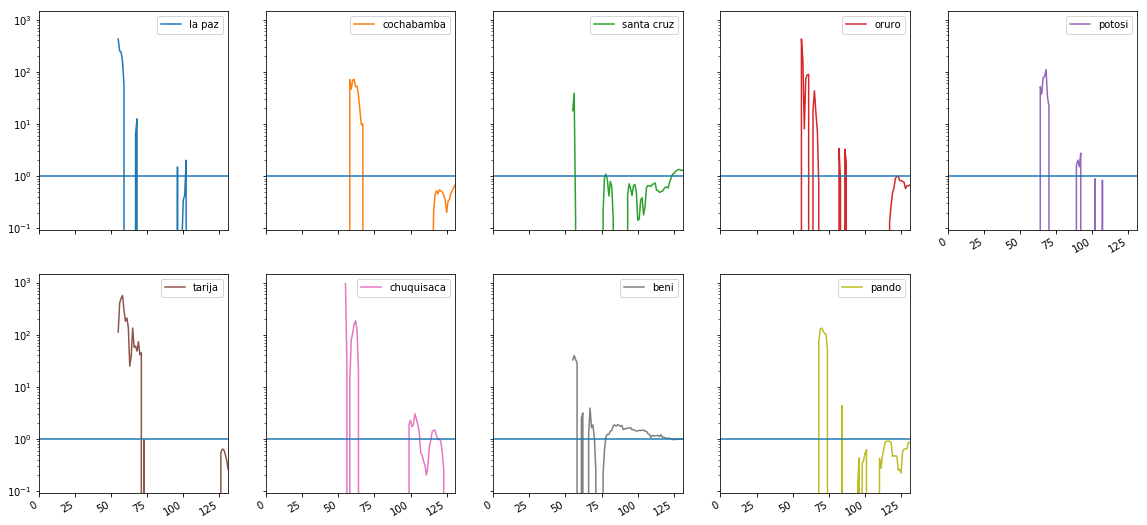

In [97]:
z = (local_daily_tests.cumsum() / population)
local_new_cases[local_new_cases < 1] = 1

prevalence_delta = np.exp(np.log(sample_prevalence).diff())
prevalence_delta = prevalence_delta.rolling(window=7).mean()

bias = (1 - prevalence_delta * (1 - z)) / z

axs = bias.plot(
    subplots=True,
    layout=(2,5), 
    sharey=True, 
    logy=True
)
_ = [ax.axhline(1.) for ax in axs.flatten()]

In [21]:
print(list(sampled_prevalence['tarija']))

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3.923076923076923, 3.466666666666667, 3.3125, 3.176470588235294, 1.4615384615384615, 1.1153846153846154, 1.1132075471698113, 0.9230769230769231, 0.7261904761904762, 0.7294117647058823, 0.7325581395348837, 0.5981308411214953, 0.5462184873949579, 0.4755244755244755, 0.46, 0.46357615894039733, 0.46710526315789475, 0.3711340206185567, 0.37435897435897436, 0.3394495412844037, 0.3155737704918033, 0.2668918918918919, 0.2668711656441718, 0.2691131498470948, 0.2590529247910863, 0.2568306010928962, 0.2371638141809291, 0.2290249433106576, 0.225531914893617, 0.22504892367906065, 0.2265625, 0.22445255474452555, 0.21951219512195122, 0.20094936708860758, 0.19148936170212766, 0.19863013698630136, 0.2138364779874214, 0.21482412060301506, 0.2222222222222222, 0.241019

In [42]:
x=(local_new_cases / local_daily_tests).rolling(window=7).mean()
x

,la paz,cochabamba,santa cruz,oruro,potosi,tarija,chuquisaca,beni,pando
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
127,0.647524,0.598577,0.543000,0.586178,0.576939,0.496074,0.756180,0.600604,0.799358
128,0.695674,0.596564,0.487838,0.632540,0.523484,0.494524,0.825305,0.622387,0.780310
129,0.674807,0.588894,0.477604,0.620243,0.523484,0.499035,0.868955,0.641272,0.780310
130,0.645872,0.587913,0.492510,0.630033,0.482188,0.525009,0.908955,0.629368,0.749348


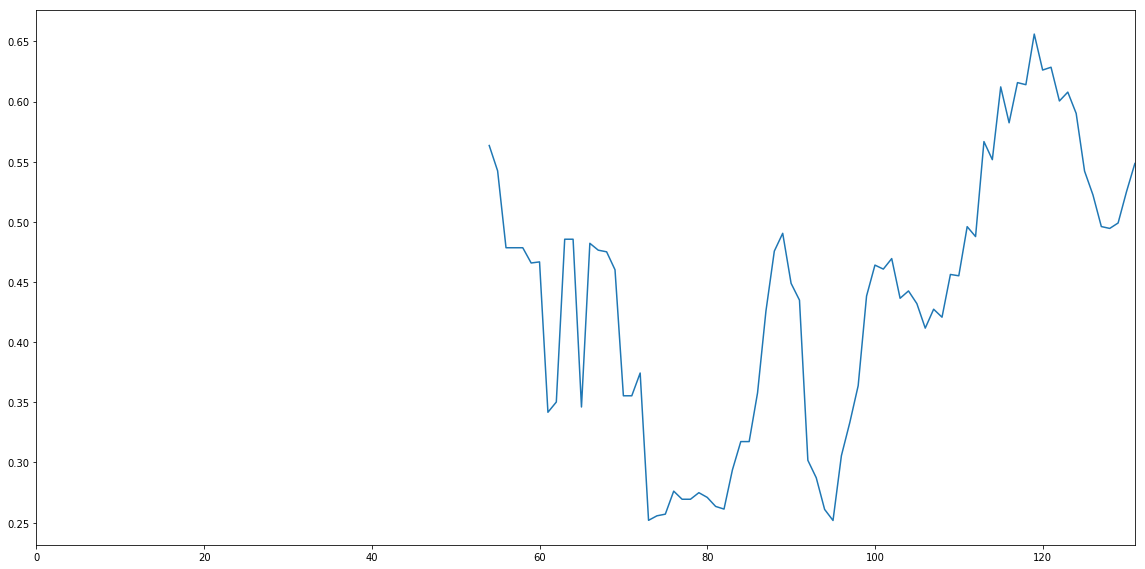

In [43]:
x['tarija'].plot()

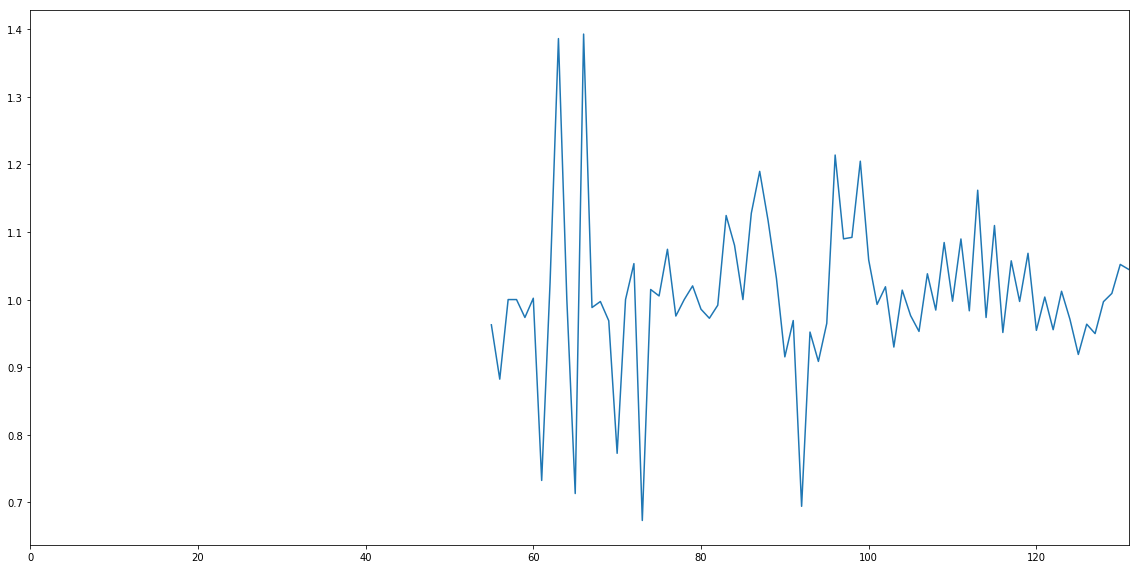

In [46]:
np.exp(np.log(x).diff())['tarija'].plot()